In [1]:
import pandas as pd
from deap import base, creator, tools, algorithms
import numpy as np
import jenkspy
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
df = pd.read_csv("../data/df_score.csv", index_col=[0])

# Jenks

In [3]:
scores_clients = df["Score_ind"]
nombre_de_classes = 6 

breaks = jenkspy.jenks_breaks(scores_clients, nombre_de_classes)
print(breaks)

[0.0, 118.9710610932476, 356.9131832797427, 508.03858520900326, 636.6559485530547, 771.7041800643087, 1000.0]


In [16]:
breaks = [0.0, 210, 356, 508, 636, 771, 900.0]

df["Classes"] = np.digitize(df["Score_ind"], bins=sorted(breaks))

resultats = df.groupby("Classes").agg(
    moyenne_TARGET=("TARGET", "mean"),
    nb_individus=("TARGET", "size"), 
)
resultats['taux_individus'] = (resultats['nb_individus'] / df.shape[0]) * 100

print(resultats)

         moyenne_TARGET  nb_individus  taux_individus
Classes                                              
1              0.271341          8856        3.162857
2              0.171879         24238        8.656429
3              0.121700         33410       11.932143
4              0.081401         44029       15.724643
5              0.054289         70382       25.136429
6              0.033507         77535       27.691071
7              0.024408         21550        7.696429


In [17]:
df["date_mensuelle"] = pd.to_datetime(df["date_mensuelle"])
df['date_trimestrielle'] = df['date_mensuelle'].dt.year.astype(str) + '_' + df['date_mensuelle'].dt.quarter.astype(str)

In [18]:
def plot_stability_taux(train, variable):
    stability_df = train.groupby(['date_trimestrielle', variable])['TARGET'].mean().unstack()
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

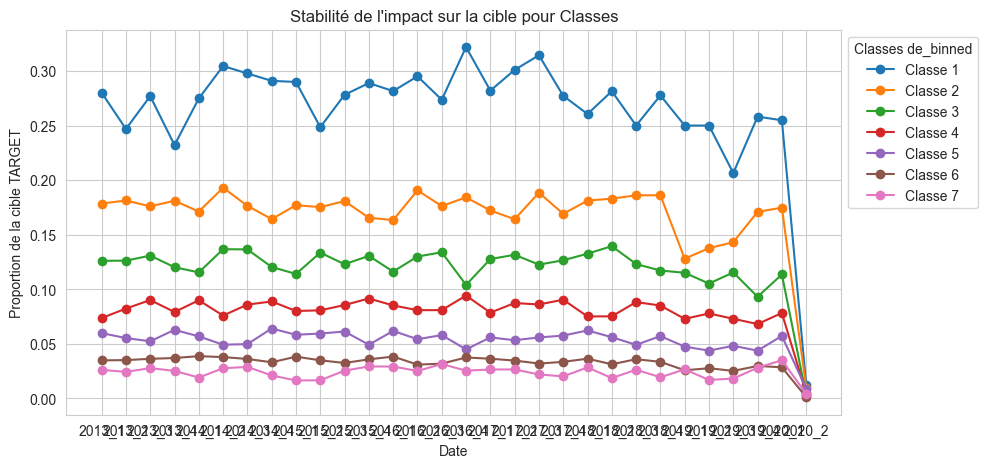

In [19]:
plot_stability_taux(df, "Classes")

# MOC C

In [30]:
resultats = df.groupby("Classes").agg(moyenne_TARGET=("TARGET", "mean")).to_dict()["moyenne_TARGET"]

In [31]:
resultats

{1: 0.27134146341463417,
 2: 0.17187886789339055,
 3: 0.121700089793475,
 4: 0.08140089486474823,
 5: 0.054289449006848345,
 6: 0.03350744824917779,
 7: 0.024408352668213458}

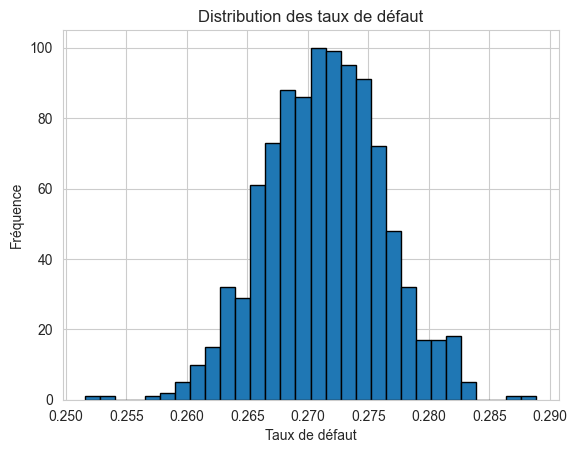

In [49]:
df_classe_1 = df[df['Classes'] == 1]
tx_defaut = []

for _ in range(1000):
    echantillon = df_classe_1["TARGET"].sample(n=len(df_classe_1), replace=True)
    
    tx_defaut.append(echantillon.mean())

deciles_np = np.array(tx_defaut)

import matplotlib.pyplot as plt

plt.hist(tx_defaut, bins=30, edgecolor='k')
plt.xlabel('Taux de défaut')
plt.ylabel('Fréquence')
plt.title('Distribution des taux de défaut')
plt.show()

In [56]:
decile9 = np.percentile(tx_defaut, 90)

In [58]:
MOC_C_classe1 = decile9 - resultats[1]
MOC_C_classe1_bis = decile9 - deciles_np.mean()

In [59]:
MOC_C_classe1

0.005984643179765103

In [60]:
MOC_C_classe1_bis

0.005998419150858192